In [ ]:
!pip install pandas-datareader==0.10.0 yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas_datareader import data as pdr
import yfinance as yfin

yfin.pdr_override()

import datetime as dt
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
ticker = 'INFY'
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2022, 1, 24)

df_full = pdr.get_data_yahoo(ticker, start=start, end=end)
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,10.30,10.34,10.23,10.29,9.635818,5688000
2020-01-03,10.29,10.35,10.26,10.31,9.654548,6992200
2020-01-06,10.22,10.25,10.17,10.21,9.560904,10068900
2020-01-07,10.12,10.17,10.10,10.10,9.457897,10589100
2020-01-08,10.00,10.12,9.99,10.09,9.448534,13440400


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 519 entries, 2020-01-02 to 2022-01-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       519 non-null    float64
 1   High       519 non-null    float64
 2   Low        519 non-null    float64
 3   Close      519 non-null    float64
 4   Adj Close  519 non-null    float64
 5   Volume     519 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 28.4 KB


In [ ]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.keras.layers.Dense(256, activation = 'relu')(self.X)
        self.logits = tf.keras.layers.Dense(self.action_size)(feed)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
%%time
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 10, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 15.130003.3, cost: 0.014517, total money: 10015.130003
CPU times: user 22.1 s, sys: 820 ms, total: 23 s
Wall time: 34.5 s


In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 10.480000, total balance 9989.520000
day 7, sell 1 unit at price 10.880000, investment 3.816800 %, total balance 10000.400001,
day 8: buy 1 unit at price 10.860000, total balance 9989.540001
day 9, sell 1 unit at price 10.850000, investment -0.092074 %, total balance 10000.390001,
day 20: buy 1 unit at price 10.960000, total balance 9989.430001
day 21, sell 1 unit at price 10.940000, investment -0.182486 %, total balance 10000.370001,
day 25: buy 1 unit at price 10.850000, total balance 9989.520000
day 26, sell 1 unit at price 10.920000, investment 0.645158 %, total balance 10000.440001,
day 27: buy 1 unit at price 10.950000, total balance 9989.490001
day 28, sell 1 unit at price 11.220000, investment 2.465758 %, total balance 10000.710001,
day 31: buy 1 unit at price 11.210000, total balance 9989.500001
day 32, sell 1 unit at price 11.300000, investment 0.802856 %, total balance 10000.800001,
day 41: buy 1 unit at price 10.210000, total balance 9990.590001
d

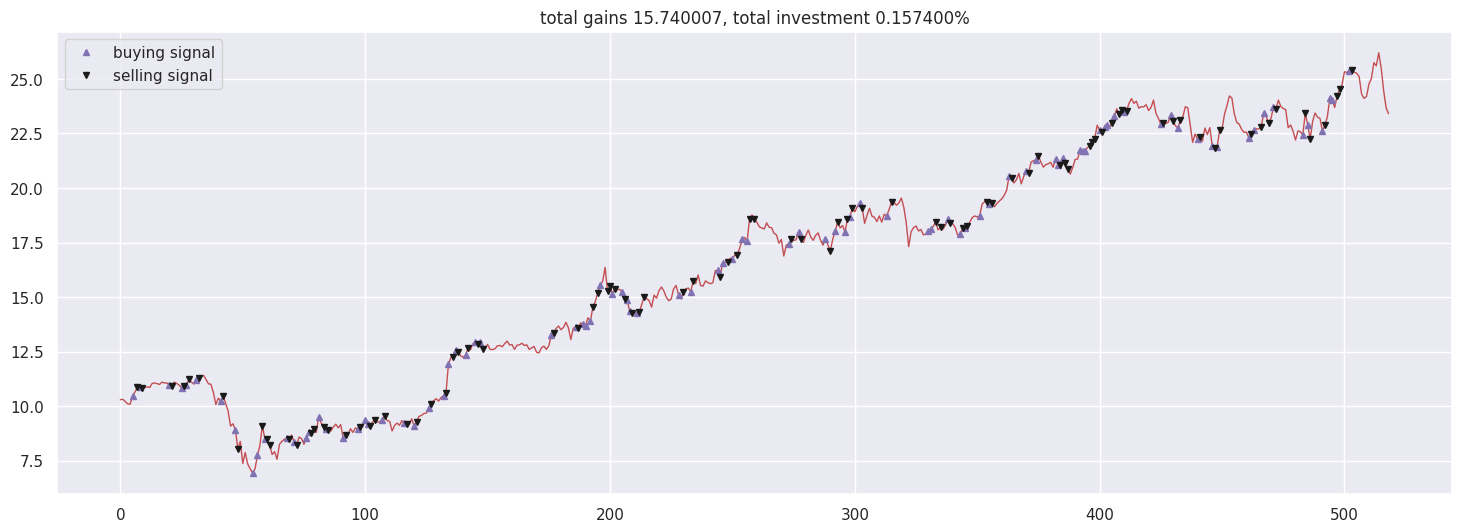

In [ ]:
fig = plt.figure(figsize = (18,6))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=5, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=5, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()